# P1 - Used Car Price Prediction
### Machine Learning - Maestría en Inteligencia Analítica para la Toma de Decisiones
### Universidad de los Andes

* Andrés Lozano - 201823473
* Lucila Noriega - 201819561
* Julian Baquero - 201215661

# Preparación de los datos

In [1]:
# Importamos las librerías que vamos a usar a lo largo del Notebook
%matplotlib inline
import pandas as pd
import category_encoders as ce
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Para realizar un análisis completo de los datos, se unen las bases train y test, las cuales dan origen a la base Big_data
data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data_test = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTest_carListings.zip', index_col=0)
Big_data=data.append(pd.DataFrame(data=data_test), ignore_index=True,sort=False)
Big_data['ind']=Big_data.index

In [3]:
print("Train shape:",data.shape)
print("Test shape:",data_test.shape)
print("Total shape:",Big_data.shape)

Train shape: (500000, 6)
Test shape: (250000, 5)
Total shape: (750000, 7)


In [4]:
#Realizamos un análisis de los NAN values para evaluar el tratamiento de los datos
missing_values_count = Big_data.isnull().sum()
missing_values_count

Price      250000
Year            0
Mileage         0
State           0
Make            0
Model           0
ind             0
dtype: int64

De acuerdo con los resultados, la única variable con missing values es "Price". La cual presenta 250.000 missing values correspondientes a los valores de la base test. Por lo tanto, sabemos que la base en general está completa y podemos avanzar nuestro análisis sin tratamientos especiales.

In [5]:
# Resumen estadístico de las variables continuas
Big_data.describe()

,Price,Year,Mileage,ind
count,500000.000000,750000.000000,7.500000e+05,750000.000000
mean,21144.186304,2013.198809,5.505032e+04,374999.500000
std,10753.259704,3.290910,4.098547e+04,216506.495284
min,5001.000000,1997.000000,5.000000e+00,0.000000
25%,13499.000000,2012.000000,2.580500e+04,187499.750000
50%,18450.000000,2014.000000,4.296500e+04,374999.500000
75%,26998.000000,2016.000000,7.732100e+04,562499.250000
max,79999.000000,2018.000000,2.457832e+06,749999.000000


De acuerdo con el resumen estadístico anterior, vemos que se entienden como continuas las variables "Price", "Year", "Mileage" y "ind" y se realiza el siguiente análisis:
* Con respecto a la variable "Year" se evidencia que el modelo más antiguo registrado en la base es 1997 y el más reciente es 2018, con una media de 2013,2 y una desviación de 3,29
* Con respecto a la variable "Price" se evidencia que el precio más bajo registrado en la base es 5.001 y el mayor es 79.999, con una media de 21.144 y una desviación de 10.753 (Precios en dólares)
* Con respecto a la variable "Mileage" se evidencia que el menor millaje es de 5 millas y el mayor de 2.457.832 millas, con una media de 55.050 y una desviación de 40.985 millas

** No se analiza la variable "ind" ya que es fue creada con el fin de registrar el índice de cada una de las filas de datos

# Análisis de los datos

In [6]:
#Graficas

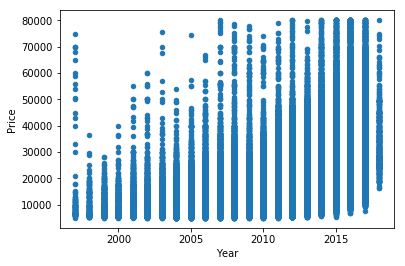

In [7]:
Big_data.plot(kind='scatter', y='Price', x='Year')

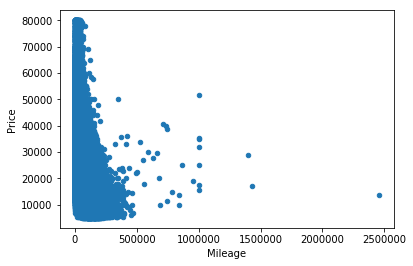

In [8]:
Big_data.plot(kind='scatter', y='Price', x='Mileage')

De acuerdo con la gráfica anterior, visualmente se observan valores atípicos con respecto a la variable "Mileage", por lo cual queremos evaluar su impacto en la base en general. Para el tratamiento inicial de estos valores proponemos reemplazarlos por la media de la base total y crear un dataset con los valores modificados

In [23]:
BD2 = Big_data.drop(['ind'],axis=1)

median = BD2.loc[BD2['Mileage']<1000000, 'Mileage'].median()

BD2.loc[BD2.Mileage> 1000000, 'Mileage'] = np.nan
BD2.fillna(median,inplace=True)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


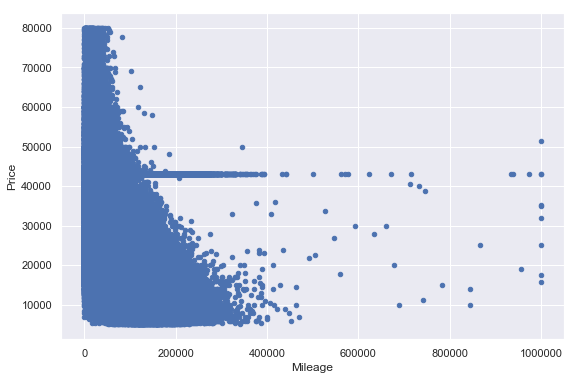

In [24]:
BD2.plot(kind='scatter', y='Price', x='Mileage')

Se evidencia que la presencia de valores atípicos distorciona la distribución de las observaciones notoriamente, sin embargo, este no es el único comportamiento irregular. Si observamos los precios entre 40.000 y 50.000, se muestra una tendencia de observaciones con un precio similar y de distinto millaje. Para evaluar el impacto de esta tendencia realizamos el siguiente histograma

C:\Users\julia\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


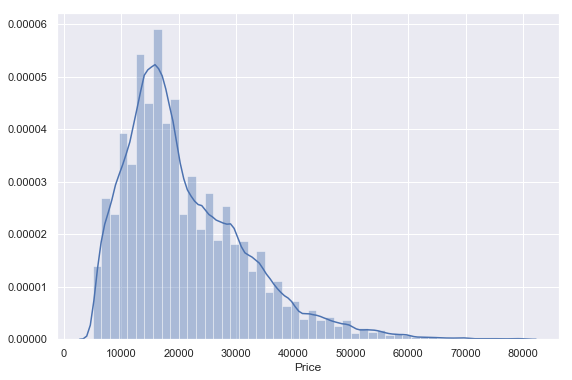

In [25]:
matplotlib.use('Agg')
matplotlib.rcParams['figure.figsize'] = (9.0, 6.0)
sns.set(color_codes=True)

sns.distplot(data["Price"]);

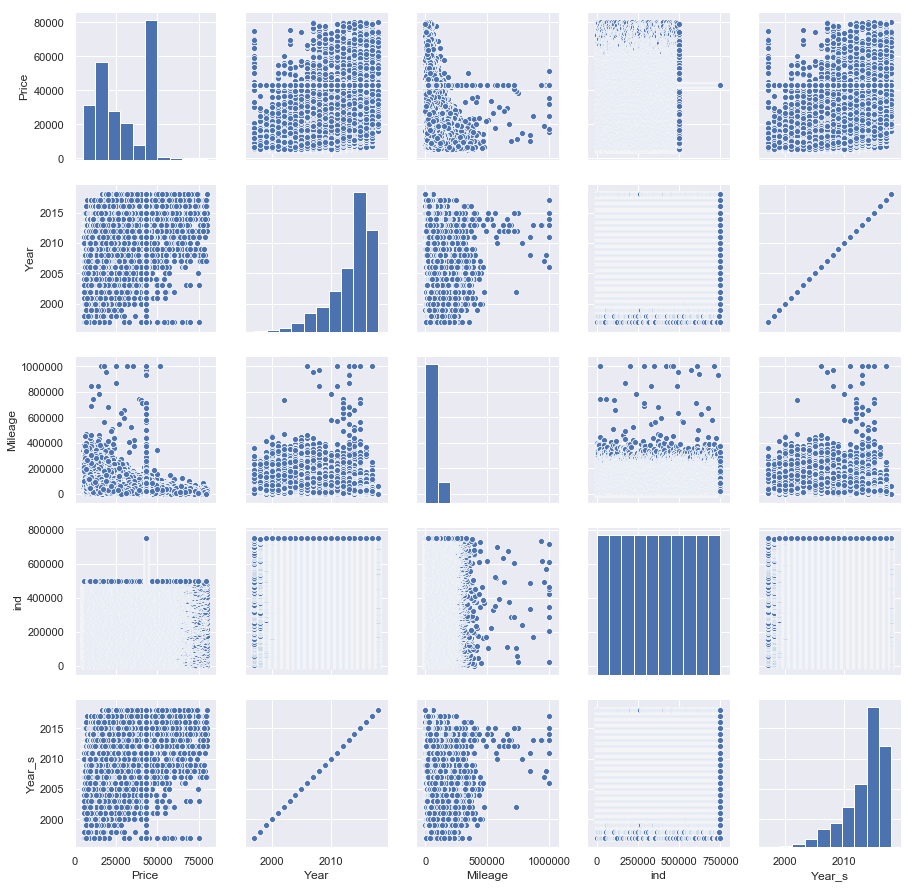

In [26]:
sns.pairplot(Big_data);

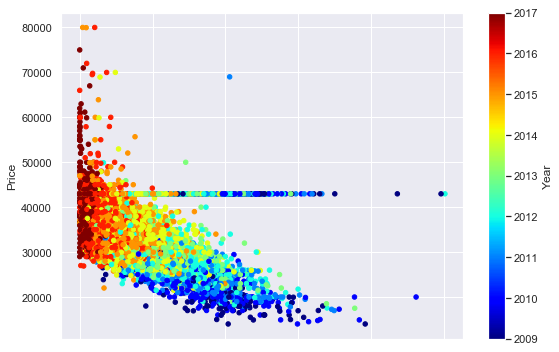

In [27]:
data1=Big_data[(Big_data["Model"]=="Wrangler") & (Big_data["Year"]<=2017)]
data1.plot(kind='scatter', y='Price', x='Mileage',c="Year",colormap='jet')

# Construcción del modelo

In [14]:
#Convertimos la variable "Year" en una variable categórica
Big_data['Year_s']=Big_data[str('Year')]

In [15]:
#Con base en las variables iniciales, creamos dummies y variables con Binary Encoder
X_1=pd.get_dummies(Big_data['Year_s'], prefix='Y')
data2=pd.DataFrame(Big_data['State'])
X_2 = ce.BinaryEncoder().fit_transform(data2)
data3=pd.DataFrame(Big_data['Make'])
X_3 = ce.BinaryEncoder().fit_transform(data3)
data4=pd.DataFrame(Big_data['Model'])
X_4 = ce.BinaryEncoder().fit_transform(data4)


In [16]:
#Creamos un nuevo Dataframe con las nuevas variables
New_data =pd.concat([Big_data[['ind','Price','Mileage']],X_1,X_2,X_3,X_4],axis=1)

In [17]:
#Separamos de nuevo los datasets train y test
train = New_data[New_data['ind']<500000]
test = New_data[New_data['ind']>=500000]

In [18]:
#Se crean las variables train y test para el ajuste y predicción del modelo
X_train = train.drop

y_train = train['Price']

X_test = test.drop(['Price','ind'],axis=1)

In [19]:
#Importamos las herramientas de la librería sklearn que van a ser empleadas en el modelo
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

clf = DecisionTreeRegressor(max_depth=20, random_state=1)

In [20]:
# Hacemos el ajuste del modelo con base en las variables de train y predecimos con la variable de test
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred=pd.DataFrame(y_pred)
y_pred['Price']=y_pred.iloc[:,0]
y_pred['ind']=y_pred.index

TypeError: float() argument must be a string or a number, not 'method'

In [ ]:
#Creamos la variable "ind" para crear el dataframe con la solución
X_test = X_test.reset_index(drop=True)
X_test['ind']=X_test.index

In [ ]:
data_test['ind']=data_test.index
y_est=pd.merge(data_test,y_pred,on='ind',how='left')
y_est.head(5)

In [ ]:
#Calculamos el promedio de los precios para los dataset de train y test
Price_model=data.groupby('Model')['Price'].mean()
Price_pred=y_est.groupby('Model')['Price'].mean()

In [ ]:
Price_model=pd.DataFrame(Price_model)
Price_pred=pd.DataFrame(Price_pred)

In [ ]:
Price_eval=pd.merge(Price_model,Price_pred,on="Model")
Price_eval

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(GaussianNB(), n_estimators=500, 
                          bootstrap=True, oob_score=True, random_state=1)

In [ ]:
X_test = X_test.drop(['ind'],axis=1)
X_test.shape

In [ ]:
clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)
y_pred2=pd.DataFrame(y_pred)
y_pred2['Price']=y_pred2.iloc[:,0]
y_pred2['ind']=y_pred2.index

X_train.shape
y_train.shape

In [ ]:
y_p = pd.DataFrame(index=data_test.index,columns=['Price'])

y_p['Price'] = clf.predict(X_test)

y_p.to_csv('test_submission2.csv', index_label='ID')

In [31]:
X_train.shape

AttributeError: 'function' object has no attribute 'shape'

In [29]:
from sklearn.ensemble import RandomForestRegressor

BG = BaggingRegressor(RandomForestRegressor(), n_estimators=500, 
                          bootstrap=True, oob_score=True, random_state=1)

BG.fit(X_train, y_train)
y_pred = BG.predict(X_test)
y_pred

ValueError: Expected 2D array, got scalar array instead:
array=<bound method DataFrame.drop of            ind    Price   Mileage  Y_1997  Y_1998  Y_1999  Y_2000  Y_2001  \
0            0  21490.0   31909.0       0       0       0       0       0   
1            1  21250.0   25741.0       0       0       0       0       0   
2            2  20925.0   24633.0       0       0       0       0       0   
3            3  14500.0   84026.0       0       0       0       0       0   
4            4  32488.0   22816.0       0       0       0       0       0   
5            5  37944.0    5362.0       0       0       0       0       0   
6            6  18995.0   69431.0       0       0       0       0       0   
7            7  28000.0   35090.0       0       0       0       0       0   
8            8  10995.0   35100.0       0       0       0       0       0   
9            9  32991.0   14238.0       0       0       0       0       0   
10          10  18995.0   97579.0       0       0       0       0       0   
11          11  15764.0   43569.0       0       0       0       0       0   
12          12  64997.0   19790.0       0       0       0       0       0   
13          13  19888.0   10627.0       0       0       0       0       0   
14          14  29500.0   23380.0       0       0       0       0       0   
15          15  17991.0   29242.0       0       0       0       0       0   
16          16  18888.0  104914.0       0       0       0       0       0   
17          17  37400.0    9799.0       0       0       0       0       0   
18          18  43783.0   40898.0       0       0       0       0       0   
19          19  33921.0   19459.0       0       0       0       0       0   
20          20  24788.0   37525.0       0       0       0       0       0   
21          21  37800.0   30586.0       0       0       0       0       0   
22          22  12995.0   84027.0       0       0       0       0       0   
23          23  24414.0   19114.0       0       0       0       0       0   
24          24  33489.0   19514.0       0       0       0       0       0   
25          25  21000.0   43454.0       0       0       0       0       0   
26          26  10250.0   78536.0       0       0       0       0       0   
27          27  15535.0   37824.0       0       0       0       0       0   
28          28  26477.0   29573.0       0       0       0       0       0   
29          29  22987.0   50300.0       0       0       0       0       0   
...        ...      ...       ...     ...     ...     ...     ...     ...   
499970  499970  37825.0    7744.0       0       0       0       0       0   
499971  499971  16988.0   42032.0       0       0       0       0       0   
499972  499972  33867.0   21503.0       0       0       0       0       0   
499973  499973  25000.0   28408.0       0       0       0       0       0   
499974  499974  13995.0   29321.0       0       0       0       0       0   
499975  499975  38946.0   26316.0       0       0       0       0       0   
499976  499976  13859.0   37820.0       0       0       0       0       0   
499977  499977  47000.0   19711.0       0       0       0       0       0   
499978  499978  13295.0   67758.0       0       0       0       0       0   
499979  499979  32000.0   11839.0       0       0       0       0       0   
499980  499980  46900.0   85834.0       0       0       0       0       0   
499981  499981  22750.0   11747.0       0       0       0       0       0   
499982  499982  23000.0   48049.0       0       0       0       0       0   
499983  499983  15997.0   43512.0       0       0       0       0       0   
499984  499984  16716.0   65762.0       0       0       0       0       0   
499985  499985  15995.0   54194.0       0       0       0       0       0   
499986  499986  14995.0   15306.0       0       0       0       0       0   
499987  499987  23000.0   22579.0       0       0       0       0       0   
499988  499988  26250.0   33374.0       0       0       0       0       0   
499989  499989  17887.0   28810.0       0       0       0       0       0   
499990  499990  30980.0    4297.0       0       0       0       0       0   
499991  499991  12990.0  110427.0       0       0       0       0       0   
499992  499992  22904.0   83474.0       0       0       0       0       0   
499993  499993  19000.0   99841.0       0       0       0       0       0   
499994  499994  20000.0   26065.0       0       0       0       0       0   
499995  499995  16997.0   40393.0       0       0       0       0       0   
499996  499996  11990.0   91794.0       0       0       0       0       0   
499997  499997  49991.0   39107.0       0       0       0       0       0   
499998  499998  21888.0   62556.0       0       0       0       0       0   
499999  499999  63973.0   17653.0       0       0       0       0       0   

        Y_2002  Y_2003    ...     Model_1  Model_2  Model_3  Model_4  Model_5  \
0            0       0    ...           0        0        0        0        0   
1            0       0    ...           0        0        0        0        0   
2            0       0    ...           0        0        0        0        0   
3            0       0    ...           0        0        0        0        0   
4            0       0    ...           0        0        0        0        0   
5            0       0    ...           0        0        0        0        0   
6            0       0    ...           0        0        0        0        0   
7            0       0    ...           0        0        0        0        0   
8            0       0    ...           0        0        0        0        0   
9            0       0    ...           0        0        0        0        0   
10           0       0    ...           0        0        0        0        0   
11           0       0    ...           0        0        0        0        0   
12           0       0    ...           0        0        0        0        0   
13           0       0    ...           0        0        0        0        0   
14           0       0    ...           0        0        0        0        0   
15           0       0    ...           0        0        0        0        0   
16           0       0    ...           0        0        0        0        0   
17           0       0    ...           0        0        0        0        0   
18           0       0    ...           0        0        0        0        0   
19           0       0    ...           0        0        0        0        0   
20           0       0    ...           0        0        0        0        0   
21           0       0    ...           0        0        0        0        0   
22           0       0    ...           0        0        0        0        0   
23           0       0    ...           0        0        0        0        0   
24           0       0    ...           0        0        0        0        0   
25           0       0    ...           0        0        0        0        0   
26           0       0    ...           0        0        0        0        0   
27           0       0    ...           0        0        0        0        0   
28           0       0    ...           0        0        0        0        0   
29           0       0    ...           0        0        0        0        0   
...        ...     ...    ...         ...      ...      ...      ...      ...   
499970       0       0    ...           0        0        0        0        0   
499971       0       0    ...           0        0        1        1        0   
499972       0       0    ...           0        0        0        0        0   
499973       0       0    ...           0        0        1        0        1   
499974       0       0    ...           0        0        1        0        0   
499975       0       0    ...           0        0        1        0        0   
499976       0       0    ...           0        0        0        0        0   
499977       0       0    ...           0        0        0        0        0   
499978       0       0    ...           0        0        0        1        0   
499979       0       0    ...           0        0        0        1        1   
499980       0       0    ...           0        0        0        0        0   
499981       0       0    ...           0        0        0        0        0   
499982       0       0    ...           0        0        0        0        0   
499983       0       0    ...           0        0        0        0        0   
499984       0       0    ...           0        0        0        0        0   
499985       0       0    ...           0        0        0        0        1   
499986       0       0    ...           0        0        0        1        1   
499987       0       0    ...           0        0        1        0        1   
499988       0       0    ...           0        0        0        0        0   
499989       0       0    ...           0        1        0        1        1   
499990       0       0    ...           0        0        1        1        0   
499991       0       0    ...           0        0        0        1        0   
499992       0       0    ...           0        1        0        1        0   
499993       0       0    ...           0        1        0        0        0   
499994       0       0    ...           0        0        0        0        1   
499995       0       0    ...           0        1        0        0        0   
499996       0       0    ...           0        0        0        0        0   
499997       0       0    ...           0        0        0        0        0   
499998       0       0    ...           0        0        0        1        0   
499999       0       0    ...           0        0        0        0        1   

        Model_6  Model_7  Model_8  Model_9  Model_10  
0             0        0        0        0         1  
1             0        0        0        1         0  
2             0        0        0        1         1  
3             0        0        1        0         0  
4             0        0        1        0         1  
5             0        0        1        0         1  
6             0        0        1        1         0  
7             0        0        1        1         1  
8             0        1        0        0         0  
9             0        1        0        0         1  
10            0        1        0        1         0  
11            0        1        0        1         1  
12            0        1        1        0         0  
13            0        1        1        0         1  
14            0        1        1        1         0  
15            0        1        1        1         1  
16            1        0        0        0         0  
17            0        1        1        1         0  
18            0        0        1        1         0  
19            1        0        0        0         1  
20            1        0        0        1         0  
21            0        1        1        0         1  
22            1        0        0        1         1  
23            1        0        1        0         0  
24            1        0        1        0         1  
25            1        0        1        1         0  
26            1        0        1        1         1  
27            1        0        1        1         1  
28            1        1        0        0         0  
29            1        1        0        0         1  
...         ...      ...      ...      ...       ...  
499970        0        0        0        1         0  
499971        1        0        0        1         1  
499972        1        0        1        0         1  
499973        1        0        0        1         1  
499974        0        1        1        0         1  
499975        0        0        1        1         1  
499976        1        1        1        0         0  
499977        1        1        1        0         1  
499978        0        1        1        1         0  
499979        0        0        1        1         1  
499980        0        1        1        1         0  
499981        0        0        0        1         0  
499982        0        0        0        0         1  
499983        0        0        1        0         0  
499984        0        0        0        0         1  
499985        0        0        1        1         1  
499986        1        1        0        0         1  
499987        0        0        0        0         1  
499988        0        0        1        1         1  
499989        0        0        0        0         0  
499990        0        1        1        0         1  
499991        0        0        1        0         1  
499992        1        1        1        0         0  
499993        0        1        1        1         0  
499994        1        0        0        0         1  
499995        1        1        1        0         1  
499996        0        0        0        1         1  
499997        0        1        1        0         0  
499998        0        1        1        0         1  
499999        1        1        1        1         0  

[500000 rows x 50 columns]>.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# API

## Contrucción

* Ingreso por medio de Putty
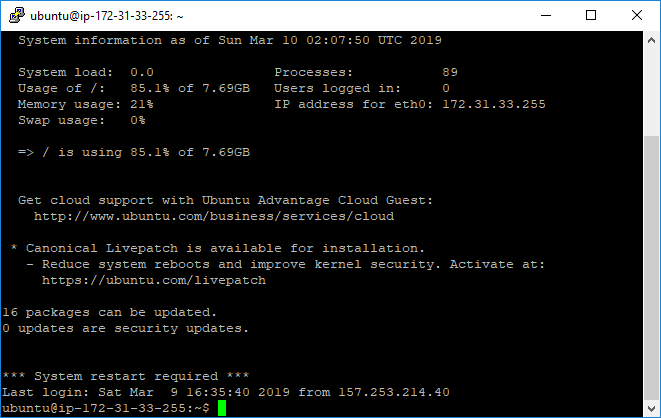

* Ingreso a la carpeta
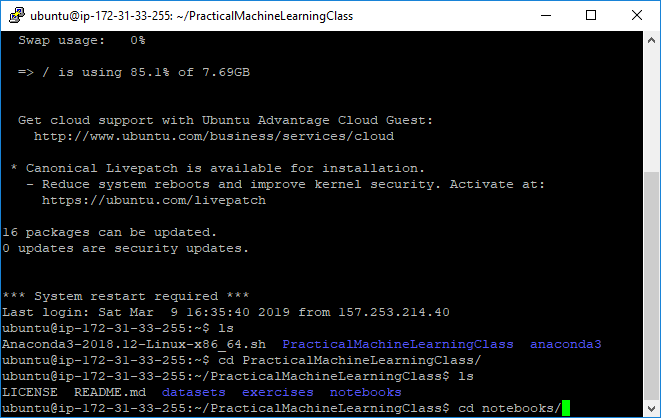


## Ejecución

* Se ejecuta el archivo api.py con el comando nohup Python api.py
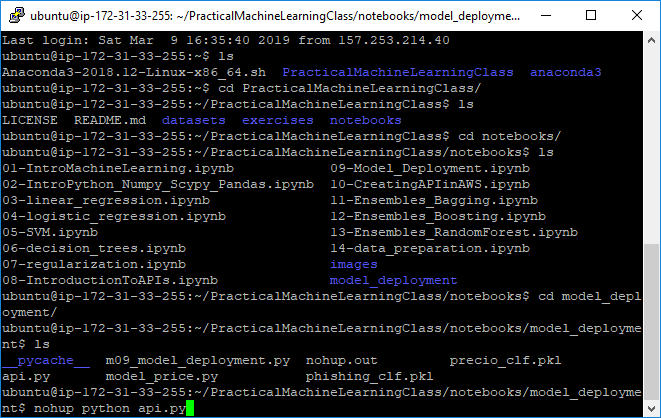

* API en ejecución:
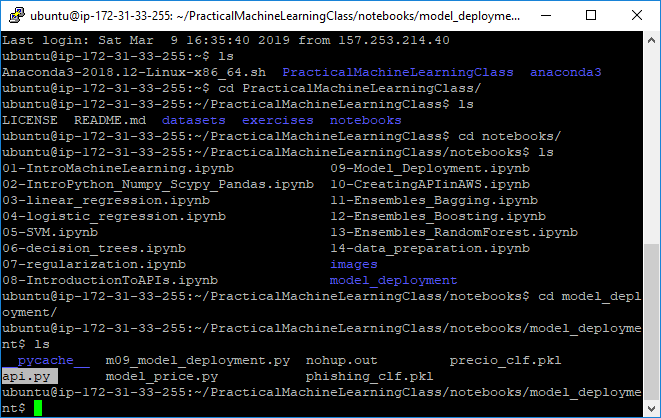

* Se actualiza la dirección ip para visualizar la app
![]('https://github.com/julianfbaquero/PracticalMachineLearningClass/blob/master/P1/EX1.png')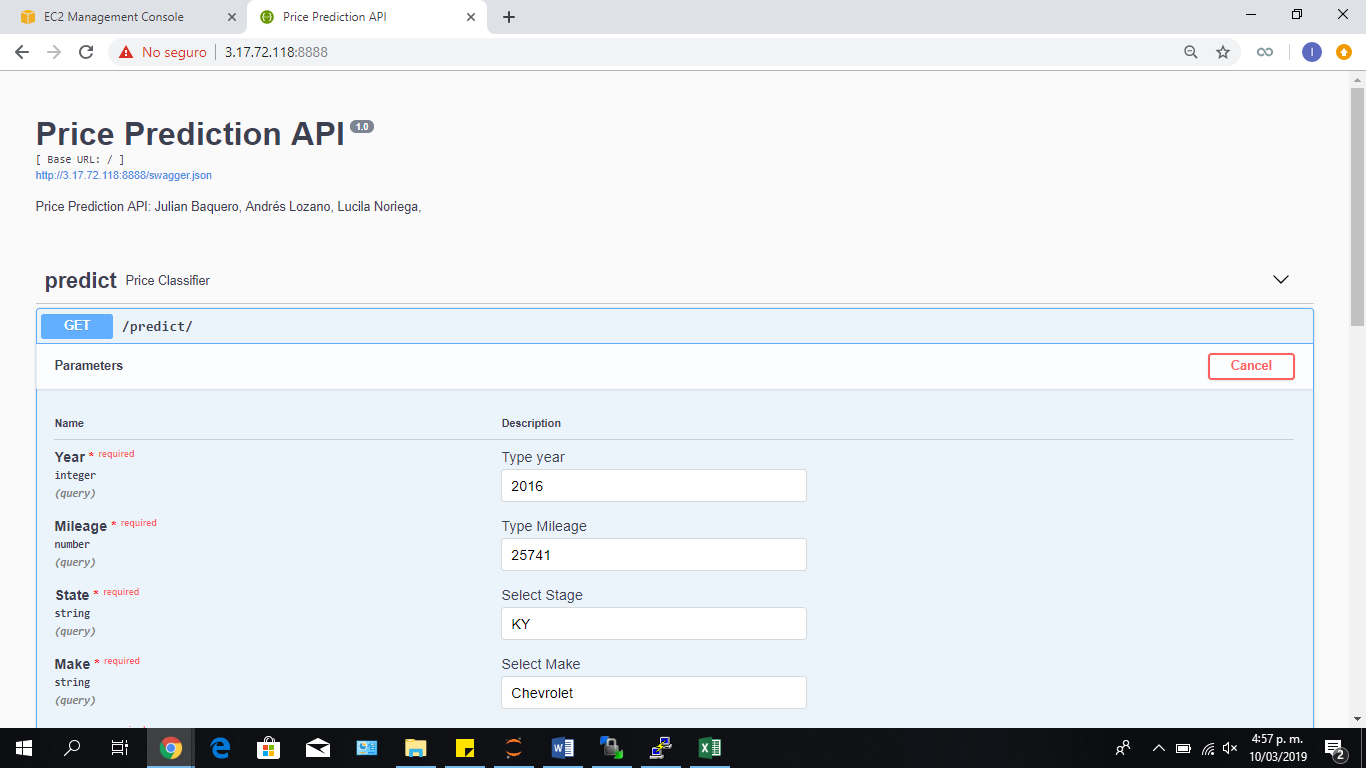

# Instrucciones para ejecutar

## El API recibe los datos exactos en cada campo. Es decir, para cada campo se deben seguir las siguientes instrucciones:

* Year: Cuatro dígitos y entre 1997 y 2018
* State: Dos caracteres en mayúsculas
* Make: Primer letra en mayúscula y el nombre debe ser el mismo que está registrado en la base
* Model: Primer letra en mayúscula y el nombre debe ser el mismo que está registrado en la base

Puede consultar la base completa para revisar los nombres de los estados, fabricantes y los modelos en el siguiente enlace:
https://github.com/julianfbaquero/PracticalMachineLearningClass/blob/master/P1/Variables-datos.pdf

## Ejemplos

* A continuación se muestran dos ejemplos de la ejecución de la app

#### Ejemplo 1:

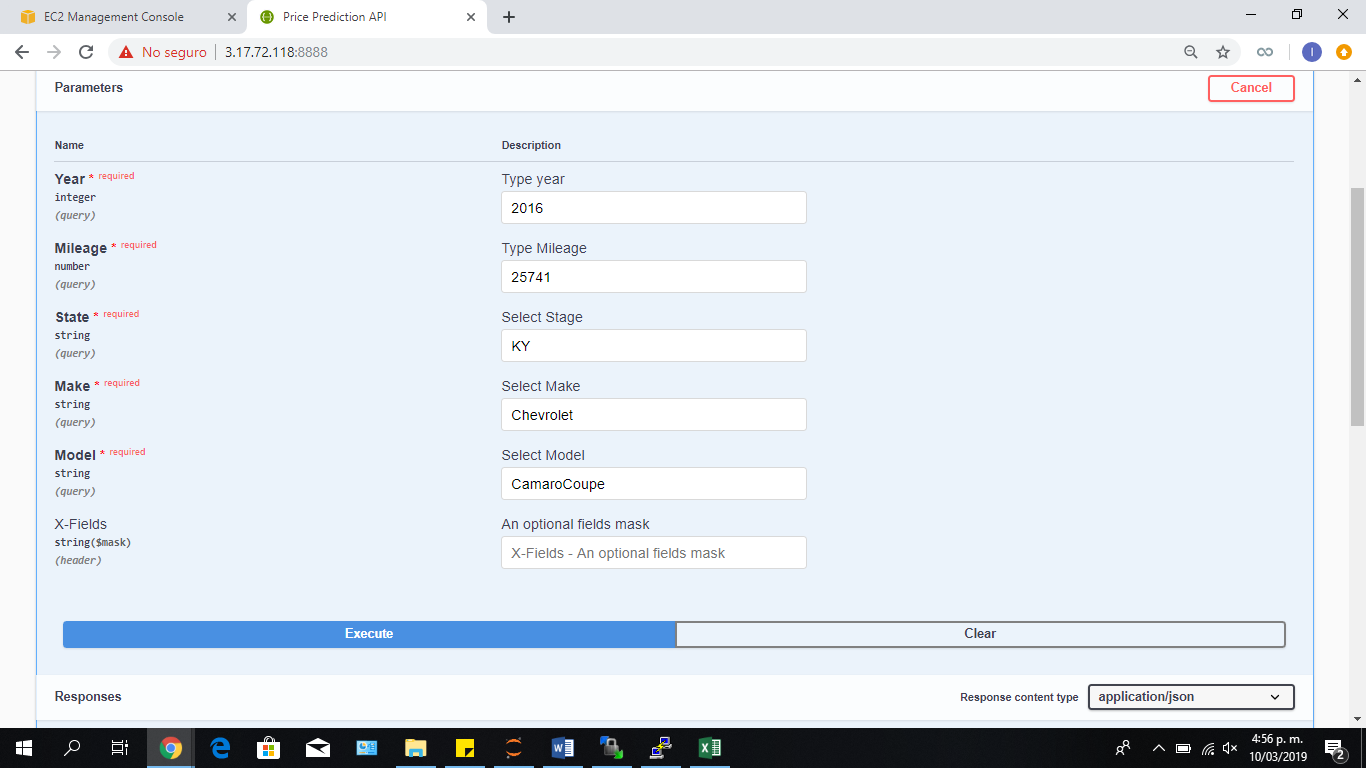
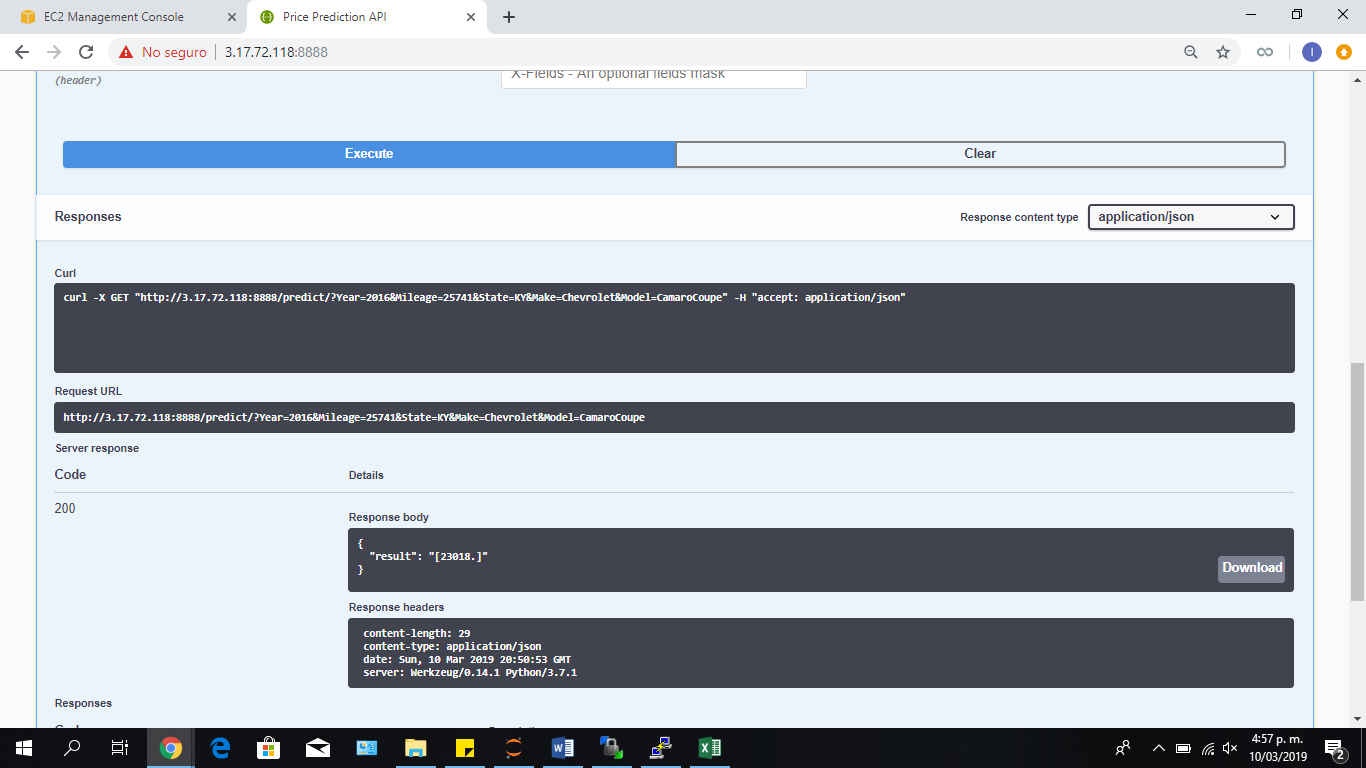

#### Ejemplo 2:
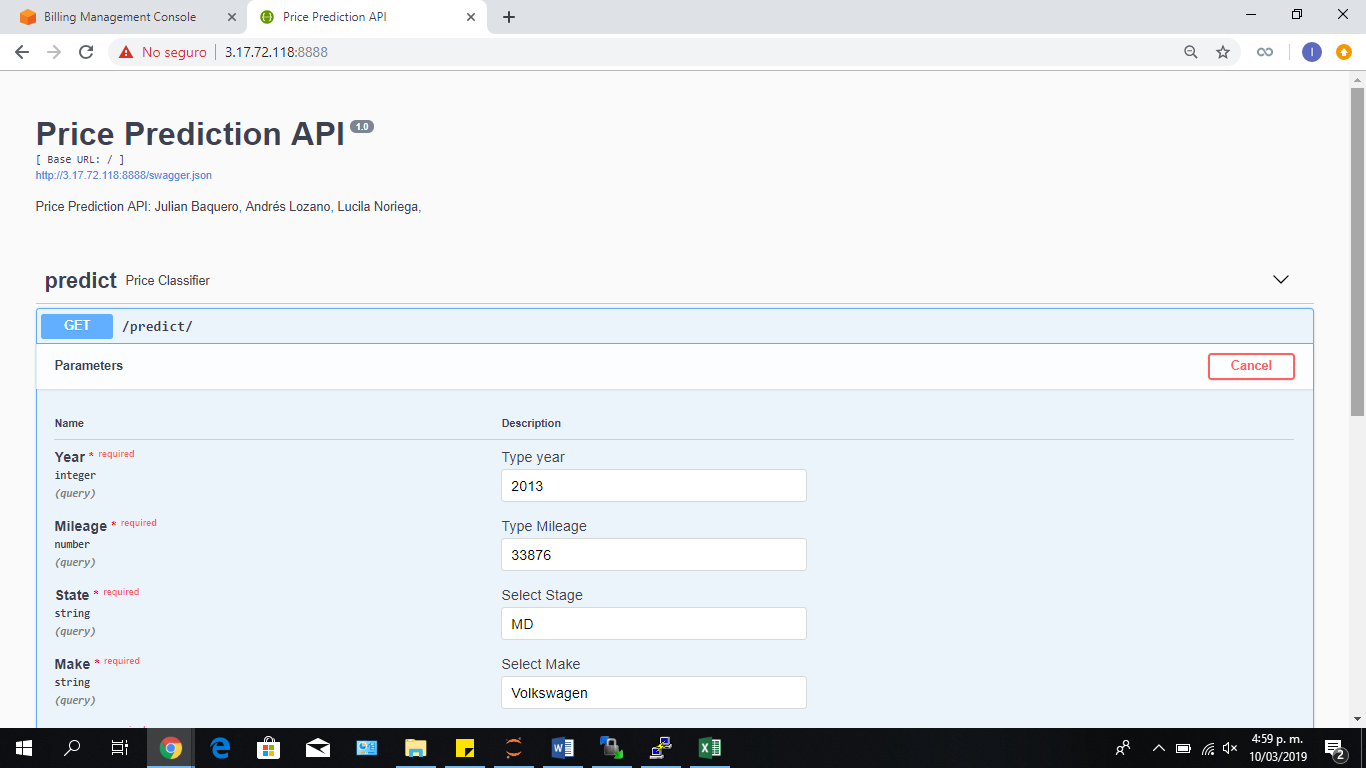
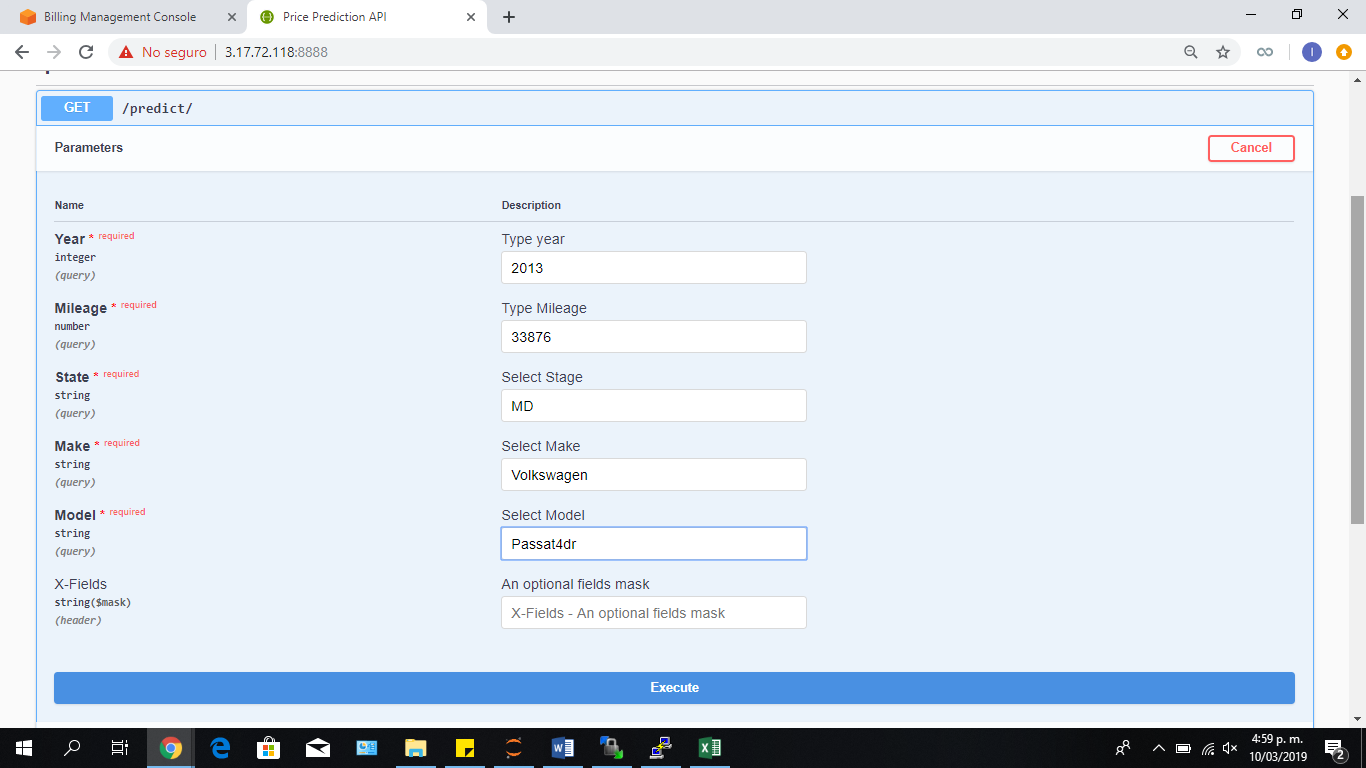
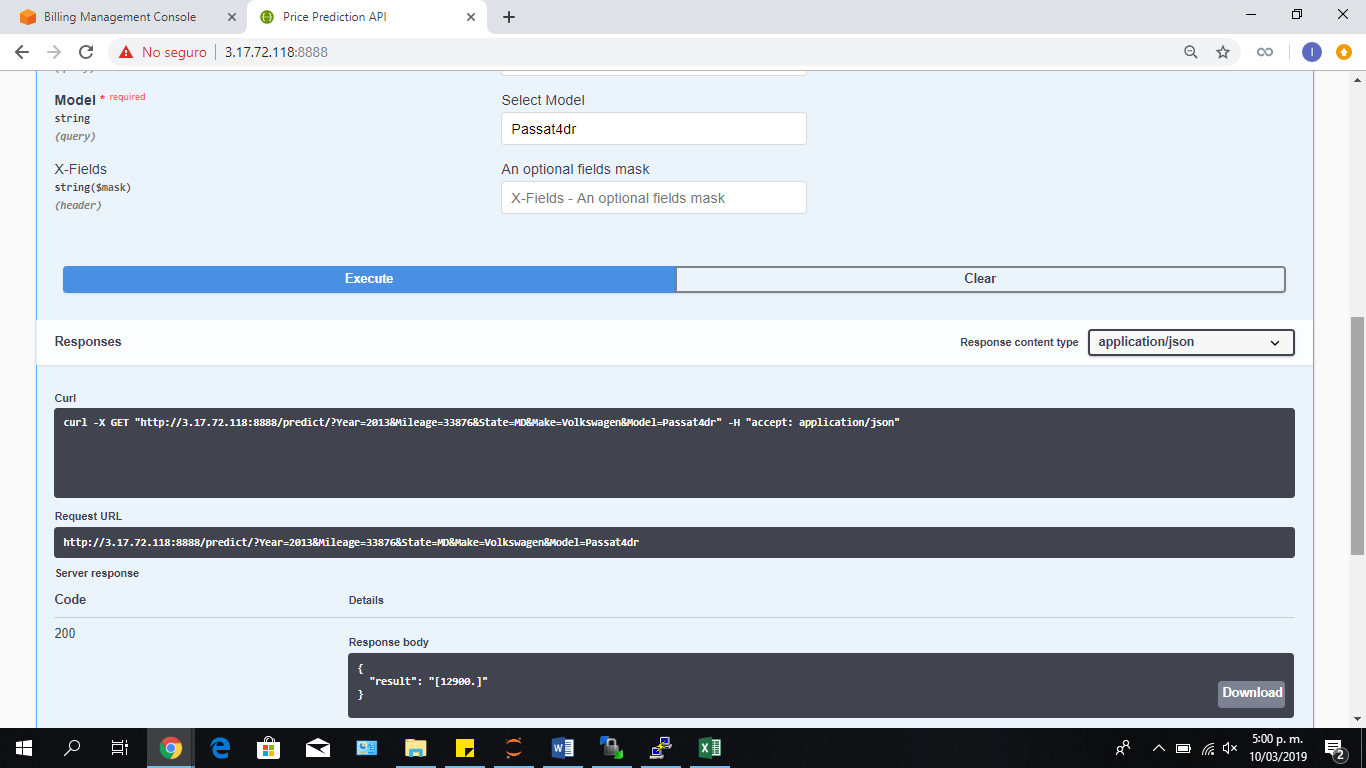

### En los dos ejemplos se muestra cómo la app arroja un resultado lógico luego de ingresar los datos solicitados